
Exercises
9.a.
Exercise: Load the Fashion MNIST dataset; split it into a training set, a validation set, and a test set; shuffle the training set; and save each dataset to multiple TFRecord files. Each record should be a serialized Example protobuf with two features: the serialized image (use tf.io.serialize_tensor() to serialize each image), and the label. Note: for large images, you could use tf.io.encode_jpeg() instead. This would save a lot of space, but it would lose a bit of image quality.

In [ ]:
import tensorflow as tf
from tensorflow import keras


(X_train_full, y_train_full), (X_test, y_test) = keras.datasets.fashion_mnist.load_data()
X_valid , X_train = X_train_full[:5000], X_train_full[5000:]
y_valid, y_train = y_train_full[:5000], y_train_full[5000:]

29515/29515 ━━━━━━━━━━━━━━━━━━━━ 0s 4us/step
26421880/26421880 ━━━━━━━━━━━━━━━━━━━━ 85s 3us/step
5148/5148 ━━━━━━━━━━━━━━━━━━━━ 0s 1us/step
4422102/4422102 ━━━━━━━━━━━━━━━━━━━━ 11s 2us/step


In [3]:
import numpy as np
keras.backend.clear_session()

np.random.seed(42)
tf.random.set_seed(42)

In [14]:
train_set = tf.data.Dataset.from_tensor_slices((X_train, y_train)).shuffle(len(X_train))
valid_set = tf.data.Dataset.from_tensor_slices((X_valid, y_valid))
test_set = tf.data.Dataset.from_tensor_slices((X_test, y_test))


In [17]:
import tensorflow as tf
from tensorflow.train import  Example, Features, Feature, BytesList, Int64List



def create_example(image, label):
    image_data = tf.io.serialize_tensor(image)
    # image_data = tf.io.encode_jpeg(image[..., np.newaxis])
    return Example(
        features=Features(
            feature={
                "image":Feature(bytes_list=BytesList(value=[image_data.numpy()])),
                "label":Feature(int64_list=Int64List(value=[label])),

            }))
        

In [18]:
for image , label in valid_set.take(1):
    print(create_example(image, label))


features {
  feature {
    key: "label"
    value {
      int64_list {
        value: 9
      }
    }
  }
  feature {
    key: "image"
    value {
      bytes_list {
        value: "\010\004\022\010\022\002\010\034\022\002\010\034"\220\006\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\001\000\000\rI\000\000\001\004\000\000\000\000\001\001\000\000\000\000\000\000\000\000\000\000\000\000\000\003\000$\210\177>6\000\000\000\001\003\004\000\000\003\000\000\000\000\000\000\000\000\000\000\000\000\006\000f\314\260\206\220{\027\000\000\000\000\014\n\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\233\354\317\262k\234\241m@\027M\202H\017\000\000\000\0

The following function saves a given dataset to a set of TFRecord files. The examples are written to the files in a round-robin fashion. To do this, we enumerate all the examples using the dataset.enumerate() method, and we compute index % n_shards to decide which file to write to. We use the standard contextlib.ExitStack class to make sure that all writers are properly closed whether or not an I/O error occurs while writing.

In [24]:
from contextlib import ExitStack

def write_tfrecords(name, dataset, n_shards=10):
    paths = ["{}.tfrecord-{:05d}-of-{:05d}".format(name, index, n_shards)
            for index in range(n_shards)]
    with ExitStack() as stack:
        writers = [stack.enter_context(tf.io.TFRecordWriter(path))
                   for path in paths]
        for index, (image, label) in dataset.enumerate():
            shard = index % n_shards
            example = create_example(image, label)
            writers[shard].write(example.SerializeToString())
        return paths        

In [25]:
train_filepaths = write_tfrecords("my_fashion_mnist.train", train_set)
valid_filepaths = write_tfrecords("my_fashion_mnist.valid", valid_set)
test_filepaths = write_tfrecords("my_fashion_mnist.test", test_set)

Exercise:b.
 Then use tf.data to create an efficient dataset for each set. Finally, use a Keras model to train these datasets, including a preprocessing layer to standardize each input feature. Try to make the input pipeline as efficient as possible, using TensorBoard to visualize profiling data.

In [30]:
def preprocess(tfrecord):
    feature_descriptions = {
        "image": tf.io.FixedLenFeature([], tf.string, default_value=""),
        "label": tf.io.FixedLenFeature([], tf.int64, default_value=1)
    }
    example = tf.io.parse_single_example(tfrecord, feature_descriptions)
    image = tf.io.parse_tensor(example["image"], out_type=tf.uint8)
    image = tf.reshape(image, shape=[28, 28])
    return image, example["label"]

def mnist_dataset(filepaths, n_read_threads=5, shuffle_buffer_size=None, n_parse_threads=5, batch_size=32, cache=True):
    dataset = tf.data.TFRecordDataset(filepaths, num_parallel_reads=n_read_threads)
    if cache:
        dataset = dataset.cache()
    if shuffle_buffer_size:
        dataset = dataset.shuffle(shuffle_buffer_size)
    dataset = dataset.map(preprocess, num_parallel_calls=n_parse_threads)
    dataset = dataset.batch(batch_size)
    return dataset.prefetch(1)        


In [31]:
train_set = mnist_dataset(train_filepaths, shuffle_buffer_size=60000)
valid_set = mnist_dataset(valid_filepaths)
test_set = mnist_dataset(test_filepaths)

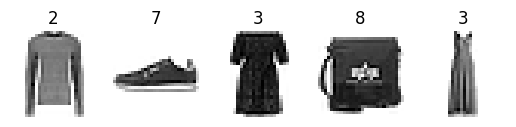

In [32]:
import matplotlib.pyplot as plt

for X, y in train_set.take(1):
    for i in range(5):
        plt.subplot(1, 5, i + 1)
        plt.imshow(X[i].numpy(), cmap="binary")
        plt.axis("off")
        plt.title(str(y[i].numpy()))


In [34]:
keras.backend.clear_session()
tf.random.set_seed(42)
np.random.seed(42)

class Standardization(keras.layers.Layer):
    def adapt(self, data_sample):
        self.means_ = np.mean(data_sample, axis=0, keepdims=True)
        self.stds_ = np.std(data_sample, axis=0, keepdims=True)
    def call(self, inputs):
        return (inputs - self.means_) / (self.stds_ + keras.backend.epsilon())

standardization = Standardization(input_shape=[28, 28])
# or perhaps soon
# standardization = keras.layers.Normalization()

sample_image_batches = train_set.take(100).map(lambda image, label: image)        
sample_images = np.concatenate(list(sample_image_batches.as_numpy_iterator()),
                              axis=0).astype(np.float32)
standardization.adapt(sample_images)

model = keras.models.Sequential([
    standardization, 
    keras.layers.Flatten(),
    keras.layers.Dense(100, activation="relu"),
    keras.layers.Dense(10, activation="softmax")
])
model.compile(loss="sparse_categorical_crossentropy",
              optimizer="nadam", metrics=["accuracy"])

C:\Users\ADMIN\AppData\Local\Temp\ipykernel_8528\3593870598.py:12: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  standardization = Standardization(input_shape=[28, 28])


In [36]:
import os
from datetime import datetime
logs = os.path.join(os.curdir, "my_logs",
                    "run_" + datetime.now().strftime("%Y%m%d_%H%M%S"))
tensorboard_cb = tf.keras.callbacks.TensorBoard(log_dir=logs, histogram_freq=1, profile_batch=10)
model.fit(train_set, epochs=5, validation_data=valid_set, callbacks=[tensorboard_cb])

Epoch 1/5
   1715/Unknown 11s 5ms/step - accuracy: 0.8034 - loss: 1732.3492

c:\Users\ADMIN\Desktop\Jupyter Projects\env\Lib\site-packages\keras\src\trainers\epoch_iterator.py:160: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


1719/1719 ━━━━━━━━━━━━━━━━━━━━ 12s 6ms/step - accuracy: 0.8035 - loss: 1740.0853 - val_accuracy: 0.8586 - val_loss: 36012.7148
Epoch 2/5
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 12s 7ms/step - accuracy: 0.8782 - loss: 2310.7104 - val_accuracy: 0.8722 - val_loss: 53385.5312
Epoch 3/5
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 13s 7ms/step - accuracy: 0.8901 - loss: 2934.2427 - val_accuracy: 0.8844 - val_loss: 3794.0176
Epoch 4/5
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 12s 7ms/step - accuracy: 0.9000 - loss: 1478.8806 - val_accuracy: 0.8764 - val_loss: 4503.2476
Epoch 5/5
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 11s 6ms/step - accuracy: 0.9067 - loss: 771.8546 - val_accuracy: 0.8856 - val_loss: 4012.1980


In [37]:
%load_ext tensorboard
%tensorboard --logdir=./my_logs --port=6006